# Bootstrapping with Coulomb Potential (Hydrogen Atom)

In this code, we demonstrate radial Coulomb potential with $\hbar = 1$ and $m_e = 1$. We begin with

\begin{align*}
    H &= \frac{P_r^2}{2m_e} + \frac{l(l+1)}{2m_er^2}\hbar^2 + V(r)\\
    V(r) &= -\frac{e^2}{4\pi\epsilon_0r} = -\frac{k}{r}\\
    [r,P_r] &= i
\end{align*}

We see that the Hamiltonian is similar to 1-D Harmonic potential, with additional angular term $\frac{l(l+1)}{2r^2}$. So we just need to consider the additional commutation relation of the additional angular term. (Denote $P_r=P$ in the following)

\begin{align*}
    [H, r^{s}P] &= 0 = 
    -\frac{1}{2}s(s-1)\langle r^{s-2}P\rangle 
    -is\langle r^{s-1}P^2\rangle
    +i\langle r^{s}V^\prime(r)\rangle
    -il(l+1)\langle r^{s-3}\rangle\\
    
    [H, r^{s-1}] &= 0 =
    -\frac{1}{2}(s-1)(s-2)\langle r^{s-3}\rangle
    -i(s-1)\langle r^{s-2}P\rangle
\end{align*}

With the same trick and the same algebraic calcukation, we get the final recursion relation
\begin{equation*}
    0 = 2sE\langle r^{s-1}\rangle + \frac{1}{4}s(s-1)(s-2)\langle r^{s-3}\rangle 
    - \langle r^s V^\prime (r)\rangle - 2s\langle r^{s-1}V(r)\rangle -(s-1)l(l+1)\langle r^{s-3}\rangle
\end{equation*}

**Note according to the author, $l=0$ case will be failed with  Bootstrapping, the reason in not clear yet.**

In [1]:
import os, time
import numpy as np
import sympy as sp
from bootstrap_sympy import sympy_solve_intervals, plot_energy_interval

import matplotlib.pyplot as plt
import seaborn as sns

## Recursion relation for 3-d Coulomb potential

Plug in $V(r)=-\frac{k}{r}$ into the recursion relation, we get

\begin{equation*}
    8(s+1)E\langle r^s\rangle = -4(2s+1)k\langle r^{s-1}\rangle
    + 4sl(l+1)\langle r^{s-2}\rangle - s(s+1)(s-1)\langle r^{s-2}\rangle
\end{equation*}

Take $s=0$ we get $\langle r^{-1}\rangle=-\frac{2E}{k}$ . If $s>0$

\begin{equation*}
    -E\langle r^s\rangle = \frac{k(2s+1)}{2(s+1)}\langle r^{s-1}\rangle
    + [\frac{s(s-1)}{8} - \frac{sl(l+1)}{2(s+1)}]\langle r^{s-2}\rangle
\end{equation*}

$\langle r^0\rangle=1$ by normalization. Take $s=1$, we get $\langle r^1\rangle=-\frac{3k}{4E}-\frac{l(l+1)}{2k}$

**Warning** : Since using sympy `solve_rational_inequalities` is slow, we transform $E^\prime = -\frac{1}{E}$, so that it will become a polynomial in $E^\prime$.

In [2]:
class ColumbPotentialMatrix:
    def __init__(self, N, angular_momentum=True):
        self.N = N # maximum size of submatrix
        self.k = sp.symbols('k') # constant of harmonic potential
        self.E = sp.symbols('E') # eigen-energy to be solved (Note the true energy is 1/E)
        self.l = sp.symbols('l') # angular momentum quantum number
        self.angular_momentum = angular_momentum
        
    def evaluate(self):
        '''
            - If assign the value of other paramters (i.e., k) first, it will give the matrix element list with only E
            - Otherwise it will represented ohter parameters with symbols
        '''
        self.rs_list = [] # list of r^s, the expectation value of position operator r to the s power
        for i in range(2*(self.N-1)+1):
            if i >= 2:
                self.rs_list.append(self.rs_recursion(s=i, rs_1=self.rs_list[i-1], rs_2=self.rs_list[i-2]))
            else:
                self.rs_list.append(self.rs_recursion(s=i))

    def rs_recursion(self, s, rs_1=None, rs_2=None):
        '''
            Find the <r^s> with recursion relation
        '''
        E = -1/self.E # Note we have transformed  E^\prime = -(1/E)
        k = self.k
        l = self.l
        if s == 0:
            return 1
        elif s == 1:
            result = -sp.Rational(3,4) * k / E
            if self.angular_momentum:
                result += -sp.Rational(1,2) * l*(l+1) / k
            return result
        else:
            if rs_1 == None or rs_2 == None:
                rs_1 = self.rs_recursion(s-1)
                rs_2 = self.rs_recursion(s-2)
            result  = k * sp.Rational(2*s+1,2*s+2) * rs_1 * (-1/E)
            result += sp.Rational(s*(s-1),8) * rs_2 * (-1/E)
            if self.angular_momentum:
                result += -sp.Rational(s,2*s+2) * l*(l+1) * rs_2 * (-1/E)
            return sp.simplify(result)

    def submatrix(self, K):
        '''
            K by K matrix's [i,j] element = <r^(i+j)>
        '''
        return sp.Matrix([[self.rs_list[i+j] for j in range(K)] for i in range(K)])

## Set hyperparameters

We set hyperparameters in the `config` dictionary. Here is some following instructions of the function `matrix.evaluate()`:
- If you want to see the expression of matrix elements and determinants with other explicit parameters (i.e., $k$), please evaluate the matrix before assigning numerical values, or just simply remove lines `matrix.k = ...`  , .etc.
- On the other hand, to accelerate the computation, please assign the numerical values (except $E$) before `matrix.evaluate()`

**Warning** : According to the author, $l=0$ will be failed.

In [3]:
# saving paths
save_dir = os.path.abspath('hydrogen')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

cp_config = {
    'round' : 25, # maximum size of submatrix to compute the determinant
    'threshold' : 1e-2, # threshold to keep small intervals
    'initial_interval' : sp.Interval(0, sp.oo), # Expect the energy after transformation to be positive
}

cp_matrix = ColumbPotentialMatrix(N=cp_config['round'], angular_momentum=True)
cp_matrix.k = 1
cp_matrix.l = 1 # set l>=1, otherwise l=0 will be failed

k, l = cp_matrix.k, cp_matrix.l
cp_config['npy_energy_intervals'] = os.path.join(save_dir, f"energy_intervals_k{sp.N(k):.2f}_l{l}.npy")
cp_config['npy_confirmed_intervals'] = os.path.join(save_dir, f"confirmed_intervals_k{sp.N(k):.2f}_l{l}.npy")

cp_matrix.evaluate()
energy_intervals, confirmed_intervals = sympy_solve_intervals(cp_matrix, cp_config, mode='Poly', keep=False)

Checkpoint exists, checkpoint max K=25



## Theoretic energy eigenvalues

For Hydrogen atom, the energy eigenvalues are $E_n=-\frac{\hbar^2}{2m_ea_0^2n^2}$, with the Bohr radius $a_0=\frac{4\pi\epsilon_0\hbar^2}{m_ee^2}=\frac{\hbar^2}{m_ek}$. We now set $m_e=\hbar=1$, the Bohr radius becomes $a_0=\frac{1}{k}$, and $E_n(k)=-\frac{k^2}{2n^2}$. Note that the energy eigenvalues are independent of $l$. However, the principal quantum number $n$ should be greater than the angular momentum quantum number $l$, i.e. $n>l$. So when solving the energy eigenvalues  with bootstrapping method, we expect the energy eigenvalues will start from $n=l+1$.

**Warning** : Since we have transform $E^\prime=-\frac{1}{E}$, the energy intervals we solved will be $E^\prime=\frac{2n^2}{k^2}$.

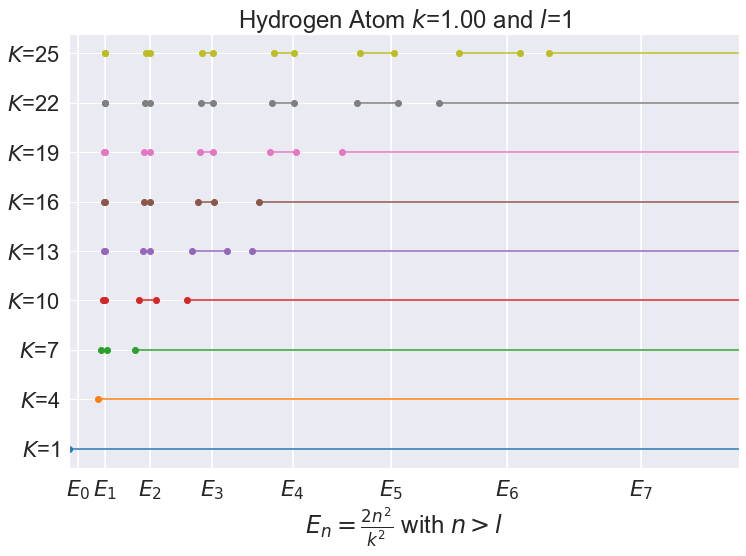

In [5]:
if confirmed_intervals != None:
    print(f"Confirmed intervals = {sp.N(confirmed_intervals)}")

cp_config['plot_step'] = 3 # how often to plot the result
cp_config['x_inf'] = 0 # infimum for x-axis when plotting
cp_config['x_sup'] = 150 # supremum for x-axis when plotting

energy_eigenvalues = [2*(n**2)/k**2 for n in range(1, cp_config['round']+1)]
x_ticks = [r"$E_{{{}}}$".format(i) for i in range(len(energy_eigenvalues))]

np.save(cp_config['npy_energy_intervals'], energy_intervals, allow_pickle=True)
np.save(cp_config['npy_confirmed_intervals'], confirmed_intervals, allow_pickle=True)

sns.set_style('dark')
sns.set(font_scale=2)
fig, ax = plot_energy_interval(energy_intervals, energy_eigenvalues, x_ticks, cp_config)
ax.set_title(f"Hydrogen Atom $k$={sp.N(k):.2f} and $l$={l}")
ax.set_xlabel(r"$E_n=\frac{2n^2}{k^2}$ with $n>l$")
plt.savefig(os.path.join(save_dir, f"result_N{cp_config['round']}_k{sp.N(k):.2f}_l{l}.png"))